In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from machinedesign.autoencoder.interface import load
import keras.backend as K
from keras.models import Model
import numpy as np
from skimage.io import imsave
from sklearn.neighbors import NearestNeighbors
from machinedesign.viz import grid_of_images_default
from sklearn.cluster import KMeans

In [2]:
job_id = '../mnist'

In [3]:
data = np.load('../results/jobs/{}/gen/generated.npz'.format(job_id))
X = data['generated']
clf = load('../../discr/digits')
clf_enc = Model(inputs=clf.layers[0].input, outputs=clf.get_layer('p_re_lu_4').output)
model = load('../results/jobs/{}'.format(job_id))
inp = model.layers[0].input
hid_layer = model.get_layer('winner_take_all_channel_1')
hid = hid_layer.output
out = model.layers[-1].output
enc = K.function([inp], hid)
dec = K.function([hid], out)

In [4]:
def F(x):
    h = enc([x])
    h = h.max(axis=(2, 3))
    h = h.reshape((h.shape[0], -1))
    return h

In [7]:
digits = np.load('../../data/digits.npz')['X'] / 255.0
htrue = F(digits[0:10000])

In [45]:
#htrue_bin = (htrue > 10).astype(int)
htrue_bin = np.round(htrue)

In [46]:
knn = NearestNeighbors(n_neighbors=5, metric='hamming')
knn.fit(htrue_bin)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='hamming',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [47]:
x = X[0:10]
hfake = F(x)
hfake_bin = np.round(htrue)

In [48]:
dist, ind = knn.kneighbors(hfake_bin, return_distance=True)
dist *= hfake.shape[1]
print(dist[0:10])

[[  0.  13.  13.  13.  14.]
 [  0.  13.  13.  14.  14.]
 [  0.  11.  11.  11.  11.]
 [  0.  12.  13.  13.  14.]
 [  0.   8.   9.   9.   9.]
 [  0.  10.  11.  11.  12.]
 [  0.  11.  12.  13.  13.]
 [  0.  12.  12.  12.  12.]
 [  0.  13.  13.  13.  13.]
 [  0.  10.  11.  11.  11.]]


In [49]:
nb = 20
xtrue = digits[ind[:, 0]][0:nb]
xfake = x[0:nb]
xall = np.concatenate((xfake, xtrue), axis=0)
im = grid_of_images_default(xall, shape=(2, len(xtrue)))
imsave('out.png', im)
print(xall.shape)

(30, 1, 28, 28)


/home/mcherti/miniconda/envs/py3/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [50]:
# Computes normalized mutual information between all possible pairs of features
from collections import defaultdict
import math

ind = np.arange(0, htrue_bin.shape[1])
h_ = htrue_bin[0:5000, ind]
m = np.zeros((h_.shape[1], h_.shape[1]))
for i in range(h_.shape[1]):
    for j in range(i, h_.shape[1]):
        ij_counts = defaultdict(int)
        icounts = defaultdict(int)
        jcounts = defaultdict(int)
        for k in range(len(h_)):
            ij_counts[(h_[k, i], h_[k, j])] += 1
            icounts[h_[k, i]] += 1
            jcounts[h_[k, j]] += 1
        #print(ij_counts)
        #print(icounts)
        #print(jcounts)
        ij_total = sum(ij_counts.values())
        i_total = sum(icounts.values())
        j_total = sum(jcounts.values())
        m[i, j] = 0.
        for (vi, vj), nb in ij_counts.items():
            pij = nb / ij_total
            pi = icounts[vi] / i_total
            pj = jcounts[vj] / j_total
            m[i, j] += pij * math.log(pij / (pi * pj))
        hi = sum((nb/i_total) * math.log(nb/i_total) for nb in icounts.values())
        hj = sum((nb/j_total) * math.log(nb/j_total) for nb in jcounts.values())
        m[i, j] /= math.sqrt(hi * hj)
        m[j, i] = m[i, j]

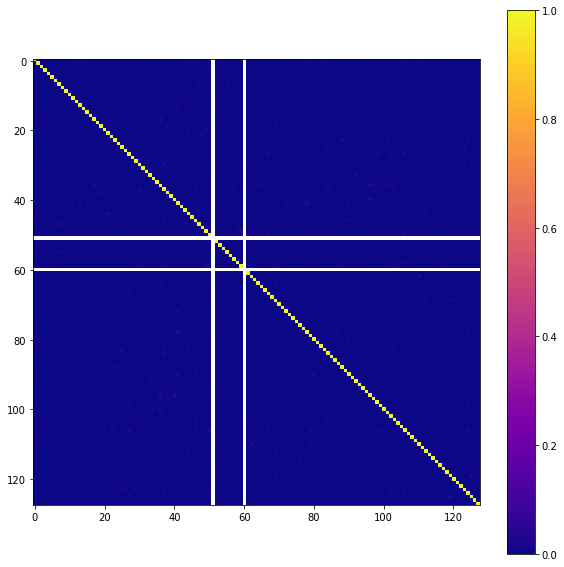

In [44]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(m, cmap='plasma')
plt.colorbar()

In [24]:
print(m)

[[  1.00000000e+00   6.40440982e-04   1.14454724e-03 ...,   1.63548185e-03
    1.54352920e-03   5.05996069e-03]
 [  6.40440982e-04   1.00000000e+00   6.19186063e-05 ...,   2.75278303e-05
    1.77611728e-04   2.28629642e-04]
 [  1.14454724e-03   6.19186063e-05   1.00000000e+00 ...,   7.23557400e-03
    4.86457293e-05   2.81824143e-04]
 ..., 
 [  1.63548185e-03   2.75278303e-05   7.23557400e-03 ...,   1.00000000e+00
    4.14351044e-02   6.90116930e-04]
 [  1.54352920e-03   1.77611728e-04   4.86457293e-05 ...,   4.14351044e-02
    1.00000000e+00   4.92466929e-04]
 [  5.05996069e-03   2.28629642e-04   2.81824143e-04 ...,   6.90116930e-04
    4.92466929e-04   1.00000000e+00]]
